<a href="https://colab.research.google.com/github/AngelRosalesContreras/Practica_3_2/blob/main/Practica_3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

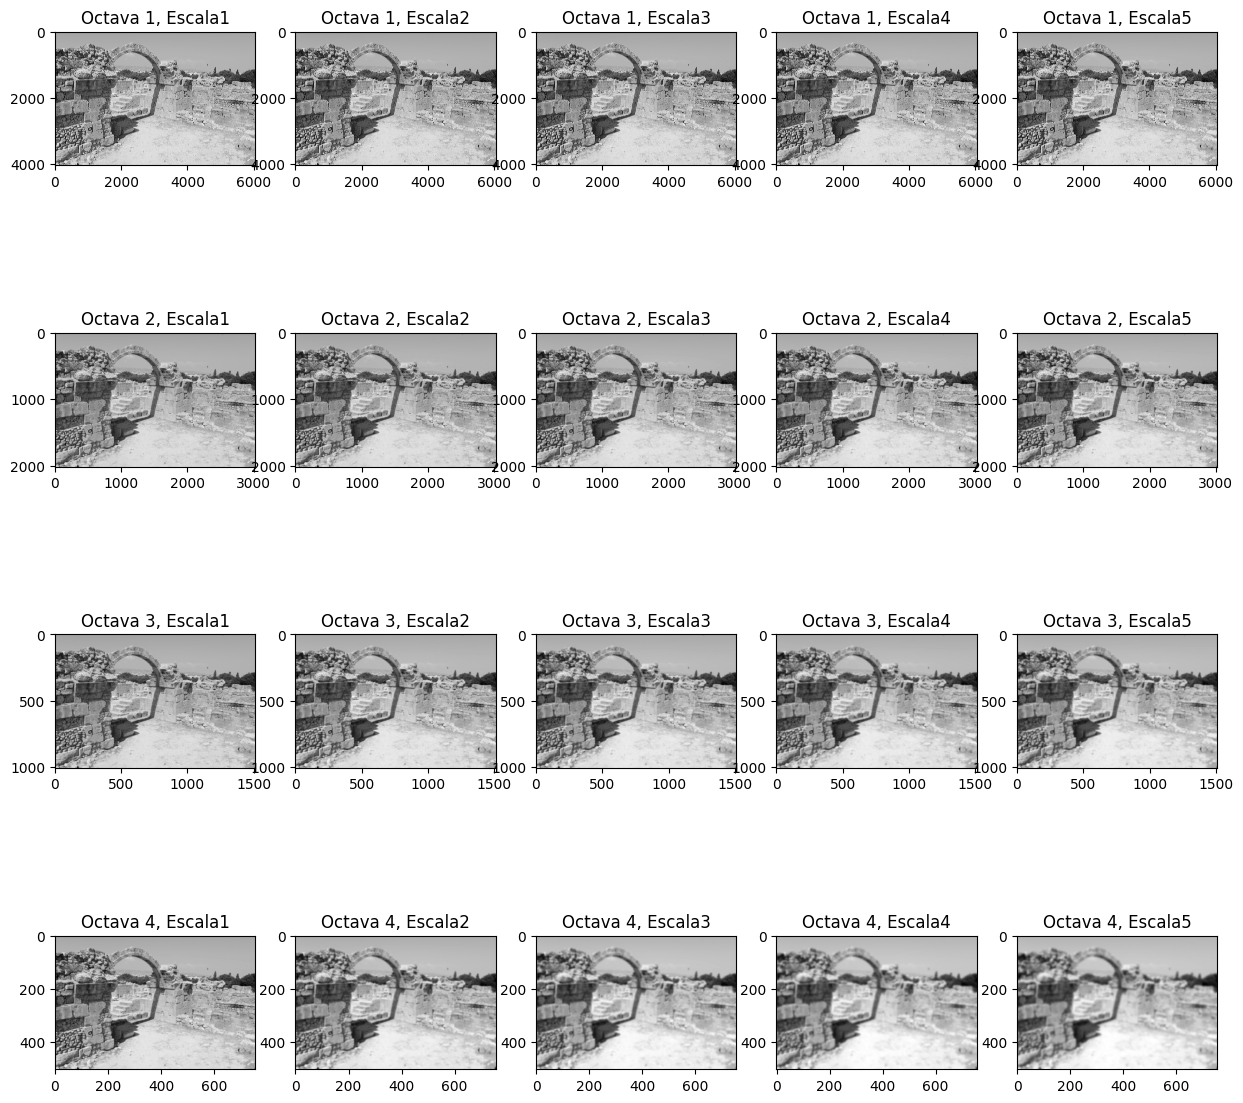

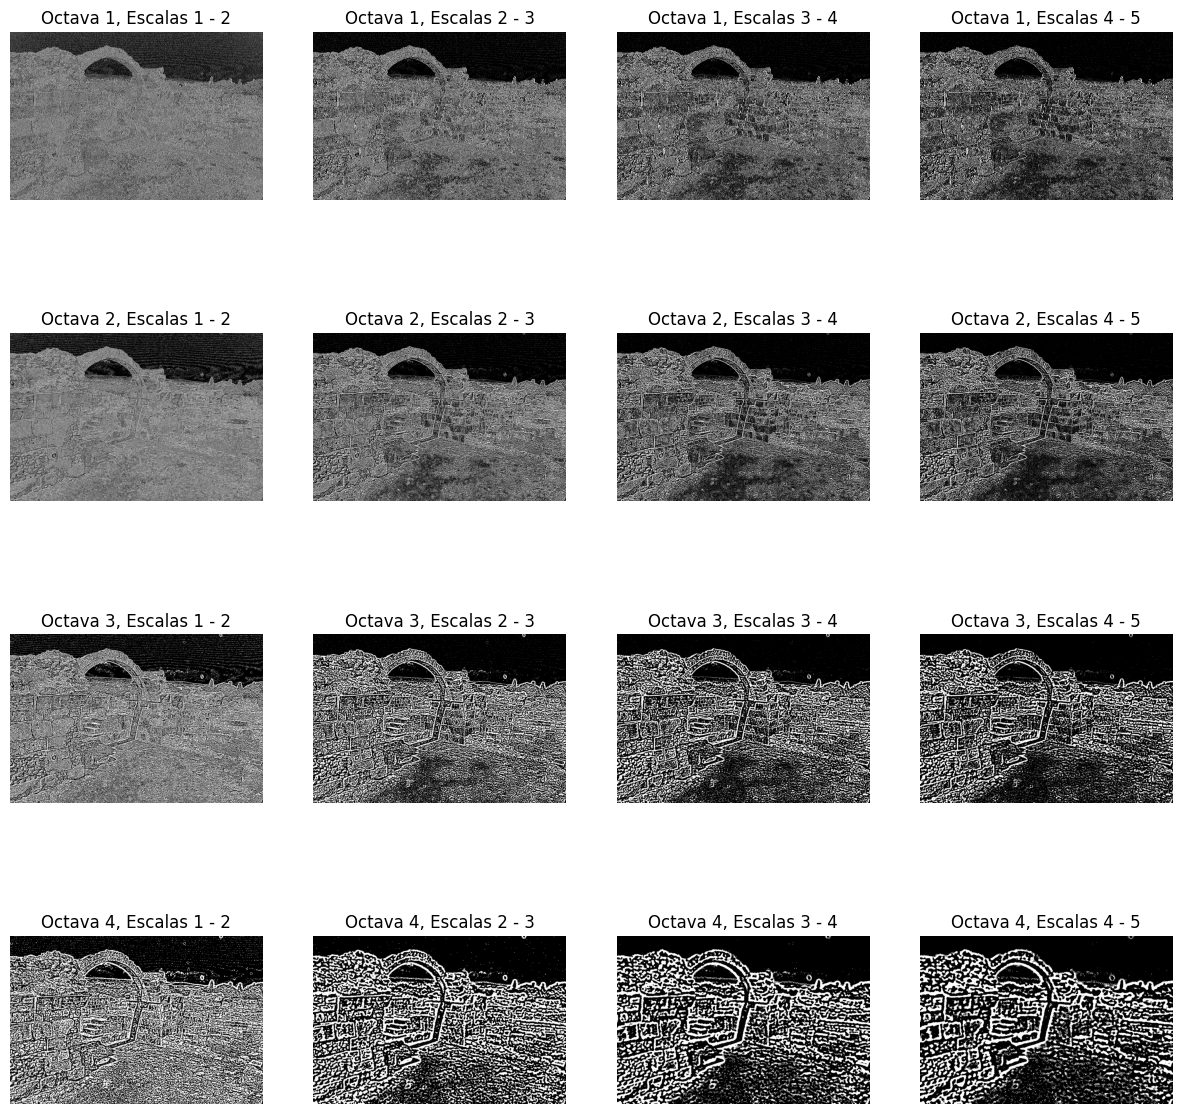

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def build_scale_space(image, num_octaves, num_scales, sigma):
    scale_space = []

    for octave in range(num_octaves):
        octave_images = []
        base = image.copy()

        for scale in range(num_scales):
            # Agregar la imagen a la escala actual
            octave_images.append(base)

            # Aplica la descomposición de escala
            base = cv2.GaussianBlur(base, (0, 0), sigmaX=sigma)

            # Actualiza el valor de sigma para la siguiente iteración
            #sigma = sigma * 2.0 if scale == 0 else sigma * np.sqrt(2)

        scale_space.append(octave_images)

        # Redimensiona la imagen para la siguiente octava
        image = cv2.pyrDown(image)

    return scale_space



def build_difference_of_gaussians(scale_space):
    dog_space = []

    scales_used = []  # Lista para almacenar la información sobre las escalas utilizadas

    for octave, octave_images in enumerate(scale_space):
        dog_octave = []
        for i in range(len(octave_images) - 1):
            difference = octave_images[i + 1] - octave_images[i]
            dog_octave.append(difference)

            # Almacena la información sobre las escalas utilizadas
            scales_used.append((octave + 1, i + 1, i + 2))

        dog_space.append(dog_octave)

    return dog_space, scales_used


def visualize_scale_space(scale_space):
    fig, axs = plt.subplots(len(scale_space), len(scale_space[0]), figsize=(15, 15))

    for octave, images in enumerate(scale_space):
        for scale, image in enumerate(images):
            axs[octave, scale].imshow(image, cmap='gray')
            axs[octave, scale].set_title(f'Octava {octave + 1}, Escala{scale + 1}')
            axs[octave, scale].axis('on')

    plt.show()

def visualize_difference_of_gaussians(dog_space, scales_used):
    fig, axs = plt.subplots(len(dog_space), len(dog_space[0]), figsize=(15, 15))

    for octave, images in enumerate(dog_space):
        for scale, image in enumerate(images):
            plt.subplot(len(dog_space), len(images), octave * len(images) + scale + 1)
            plt.imshow(image, cmap='gray')

            # Obtener la información sobre las escalas para esta imagen
            scale_info = scales_used[octave * len(images) + scale]
            plt.title(f'Octava {scale_info[0]}, Escalas {scale_info[1]} - {scale_info[2]}')
            plt.axis('off')

    plt.show()


# Cargar una imagen de ejemplo
image_path = 'DSC_6492.JPG'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Construir el espacio de escalas con parámetros personalizables
scale_space = build_scale_space(image, num_octaves=4, num_scales=5, sigma=1.6)

# Visualizar el espacio de escalas
visualize_scale_space(scale_space)

# Construir el espacio de diferencia de gaussianas y obtener la información sobre las escalas
dog_space, scales_used = build_difference_of_gaussians(scale_space)

# Visualizar el espacio de diferencia de gaussianas con información sobre las escalas
visualize_difference_of_gaussians(dog_space, scales_used)

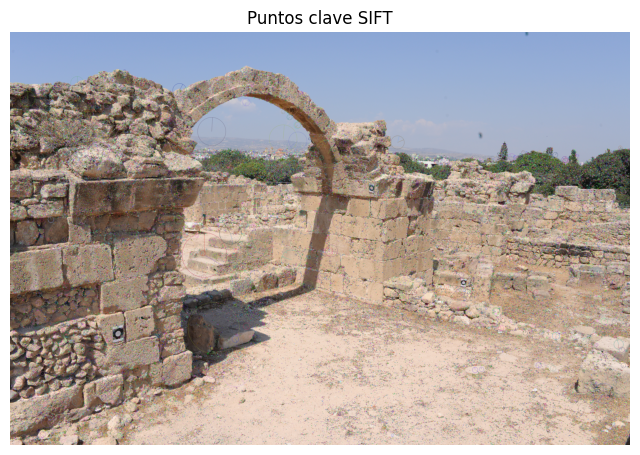

In [ ]:
def detect_and_visualize_keypoints(image_path):
    # Leyendo la imagen
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Creando el objeto SIFT
    sift = cv2.SIFT_create()

    # Detectar keypoints y calcular descriptores
    keypoints, descriptors = sift.detectAndCompute(gray_image, None)

    # Visualizar keypoints en la imagen original
    visualize_keypoints(image, keypoints)

def visualize_keypoints(image, keypoints):
    image_color = image.copy()

    image_with_keypoints = cv2.drawKeypoints(image_color, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # Mostrar la imagen con puntos clave
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(image_with_keypoints, cv2.COLOR_BGR2RGB))
    plt.title('Puntos clave SIFT')
    plt.axis('off')
    plt.show()

# Detectar y visualizar keypoints
detect_and_visualize_keypoints(image_path)


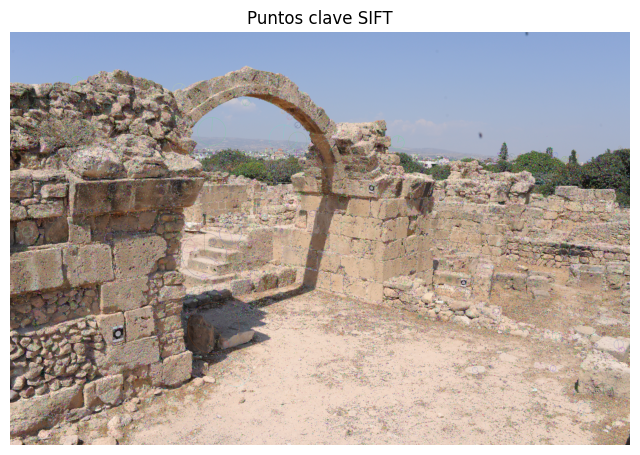

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_orientation_histogram(keypoints_with_orientations):
    # Extraer ángulos y magnitudes
    angles = np.deg2rad([angle for _, angle, _ in keypoints_with_orientations])
    magnitudes = [magnitude for _, _, magnitude in keypoints_with_orientations]

    # Crear histograma de orientaciones
    plt.figure(figsize=(8, 6))
    plt.hist(angles, bins=36, weights=magnitudes, color='purple', edgecolor='black')
    plt.title('Histograma de Orientación')
    plt.xlabel('Ángulos (radianes)')
    plt.ylabel('Magnitud')
    plt.show()

# Detectar y visualizar keypoints con histograma de orientaciones
detect_and_visualize_keypoints(image_path)

**Descriptor de puntos clave**

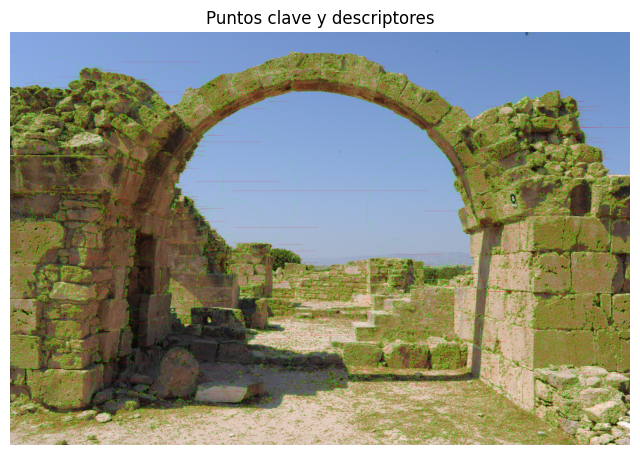

In [58]:
def detect_and_visualize_keypoints1(image_path):
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    sift = cv2.SIFT_create()

    # Detectar keypoints y calcular descriptores
    keypoints, descriptors = sift.detectAndCompute(gray_image, None)

    return keypoints, descriptors

def compute_descriptor_at_point(x, y, scale, dog_octave):
    descriptor_size = 16  # Tamaño del descriptor
    descriptor = []

    # Obtener el área alrededor del punto clave
    window_size = int(descriptor_size / 2)
    region = dog_octave[y - window_size:y + window_size + 1, x - window_size:x + window_size + 1]

    # Dividir la región en 16 sub-bloques de 4x4
    subblock_size = 4
    for i in range(4):
        for j in range(4):
            subblock = region[i * subblock_size:(i + 1) * subblock_size, j * subblock_size:(j + 1) * subblock_size]
            # Calcular el histograma de gradientes para el sub-bloque
            subblock_histogram = compute_gradient_histogram(subblock)
            # Agregar el histograma al descriptor
            descriptor.extend(subblock_histogram)

    # Normalizar el descriptor
    descriptor /= np.linalg.norm(descriptor)

    return descriptor

def compute_gradient_histogram(region):
    # Calcular gradientes en dirección x e y
    gradient_x = np.gradient(region, axis=1)
    gradient_y = np.gradient(region, axis=0)

    # Calcular magnitudes y ángulos de gradientes
    magnitudes = np.sqrt(gradient_x**2 + gradient_y**2)
    angles = np.arctan2(gradient_y, gradient_x)

    # Crear histograma de orientaciones
    histogram_bins = 8
    histogram_range = (0, 2 * np.pi)
    histogram, _ = np.histogram(angles, bins=histogram_bins, range=histogram_range, weights=magnitudes)

    return histogram

def visualize_image_with_keypoint_descriptors(image, keypoints, descriptors):
    image_with_keypoints = image.copy()

    for keypoint, descriptor in zip(keypoints, descriptors):
        x, y = int(keypoint.pt[0]), int(keypoint.pt[1])
        scale = keypoint.size

        # Dibujar un círculo en el punto clave
        cv2.circle(image_with_keypoints, (x, y), int(scale), (0, 255, 0), 1)

        # Dibujar una línea que representa el descriptor
        line_length = int(scale * 3)
        angle = np.deg2rad(descriptor.sum() * 360)  # Convertir la suma del descriptor en ángulo
        line_end = (int(x + line_length * np.cos(angle)), int(y + line_length * np.sin(angle)))
        cv2.line(image_with_keypoints, (x, y), line_end, (0, 0, 255), 1)

    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(image_with_keypoints, cv2.COLOR_BGR2RGB))
    plt.title('Puntos clave y descriptores')
    plt.axis('off')
    plt.show()

image_path = 'DSC_6500.JPG'
image = cv2.imread(image_path)

keypoints, descriptors = detect_and_visualize_keypoints1(image_path)

visualize_image_with_keypoint_descriptors(image, keypoints, descriptors)

In [ ]:
def feature_matching(img1, img2):
    # Convertir imágenes a escala de grises
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Crear el objeto SIFT
    sift = cv2.xfeatures2d.SIFT_create()

    # Detectar keypoints y calcular descriptores para ambas imágenes
    keypoints_1, descriptors_1 = sift.detectAndCompute(img1_gray, None)
    keypoints_2, descriptors_2 = sift.detectAndCompute(img2_gray, None)

    # Realizar el matching de características
    bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
    matches = bf.match(descriptors_1, descriptors_2)
    matches = sorted(matches, key=lambda x: x.distance)

    # Dibujar los primeros 50 matches
    img_matches = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:50], img2, flags=2)

    # Mostrar la imagen con los matches
    plt.figure(figsize=(8, 8))
    plt.imshow(img_matches)
    plt.title('Matches de características SIFT')
    plt.axis('off')
    plt.show()

# Rutas de las imágenes
img1_path = 'DSC_6492'
img2_path = 'DSC_6500'

# Realizar feature matching para las dos imágenes
img1 = cv2.imread(img1_path)
img2 = cv2.imread(img2_path)
feature_matching(img1, img2)

error: ignored